In [3]:
pip install geopandas

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 323 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 6.1 MB 20.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.5 MB 16.0 MB/s eta 0:00:01
     |████████████████████████████████| 20.6 MB 13.2 MB/s eta 0:00:01
     |████████████████████████████████| 163 kB 20.0 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# need to install geopandas, matplotlib

import geopandas as gpd
import os
import sys

sys.path.append(".")
import Atlas

In [2]:
do_pctSF = gpd.read_file("./data/Duplin_C_Onslow_P_")
nc_pctSF = gpd.read_file("./data/pct21")
nc_pctSF["NAME"] = nc_pctSF.index.map(lambda ii: nc_pctSF.loc[ii, "county"] + \
                                      "_" + nc_pctSF.loc[ii, "prec_id"])


In [3]:
def assignPlan(pctSF, assignment, identifier):
    pctSF["dist"] = float("nan")
    for ind in pctSF.index:
        pct = pctSF.loc[ind, identifier]
        key = str([pct]).replace("\'", "\"")
        if key in assignment:
            pctSF.loc[ind, "dist"] = assignment[key]
    return pctSF

In [4]:
import matplotlib
colorMap = [
(202,178,214),#lp
(51,160,44), #dgrn
(166,206,227),
(178,223,138),
(177,89,40), #dbrn
(251,154,153),
(253,191,111),
(255,127,0),
(106,61,154),
(255,255,153),
(31,120,180),
(227,26,28),
(127,26,28),
(153,191,11)
]

for i in range(len(colorMap)):
    colorMap[i] = (colorMap[i][0]/255.0, 
                   colorMap[i][1]/255.0, 
                   colorMap[i][2]/255.0)
    
mycmap = matplotlib.colors.ListedColormap(colorMap)

import random
random.seed(1413133)
colors50 = []
for ii in range(50):
    rndColor = (random.uniform(0.25,1),
                random.uniform(0.25,1),
                random.uniform(0.25,1))
    colors50.append(rndColor)

mycmap50 = matplotlib.colors.ListedColormap(colors50)

random.seed(14113)
colors120 = []
for ii in range(120):
    rndColor = (random.uniform(0.25,1),
                random.uniform(0.25,1),
                random.uniform(0.25,1))
    colors120.append(rndColor)

mycmap120 = matplotlib.colors.ListedColormap(colors120)

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def save_fig(pctSF, cmp, vmx, outDir, name, displayPlot=False):
    pctSF.plot(figsize=(20,20), vmin=1, vmax=vmx, column="dist", cmap=cmp, 
               edgecolor="black", linewidth=0.2)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(outDir, name + ".png"), dpi=200)
    if not displayPlot :
        plt.close()

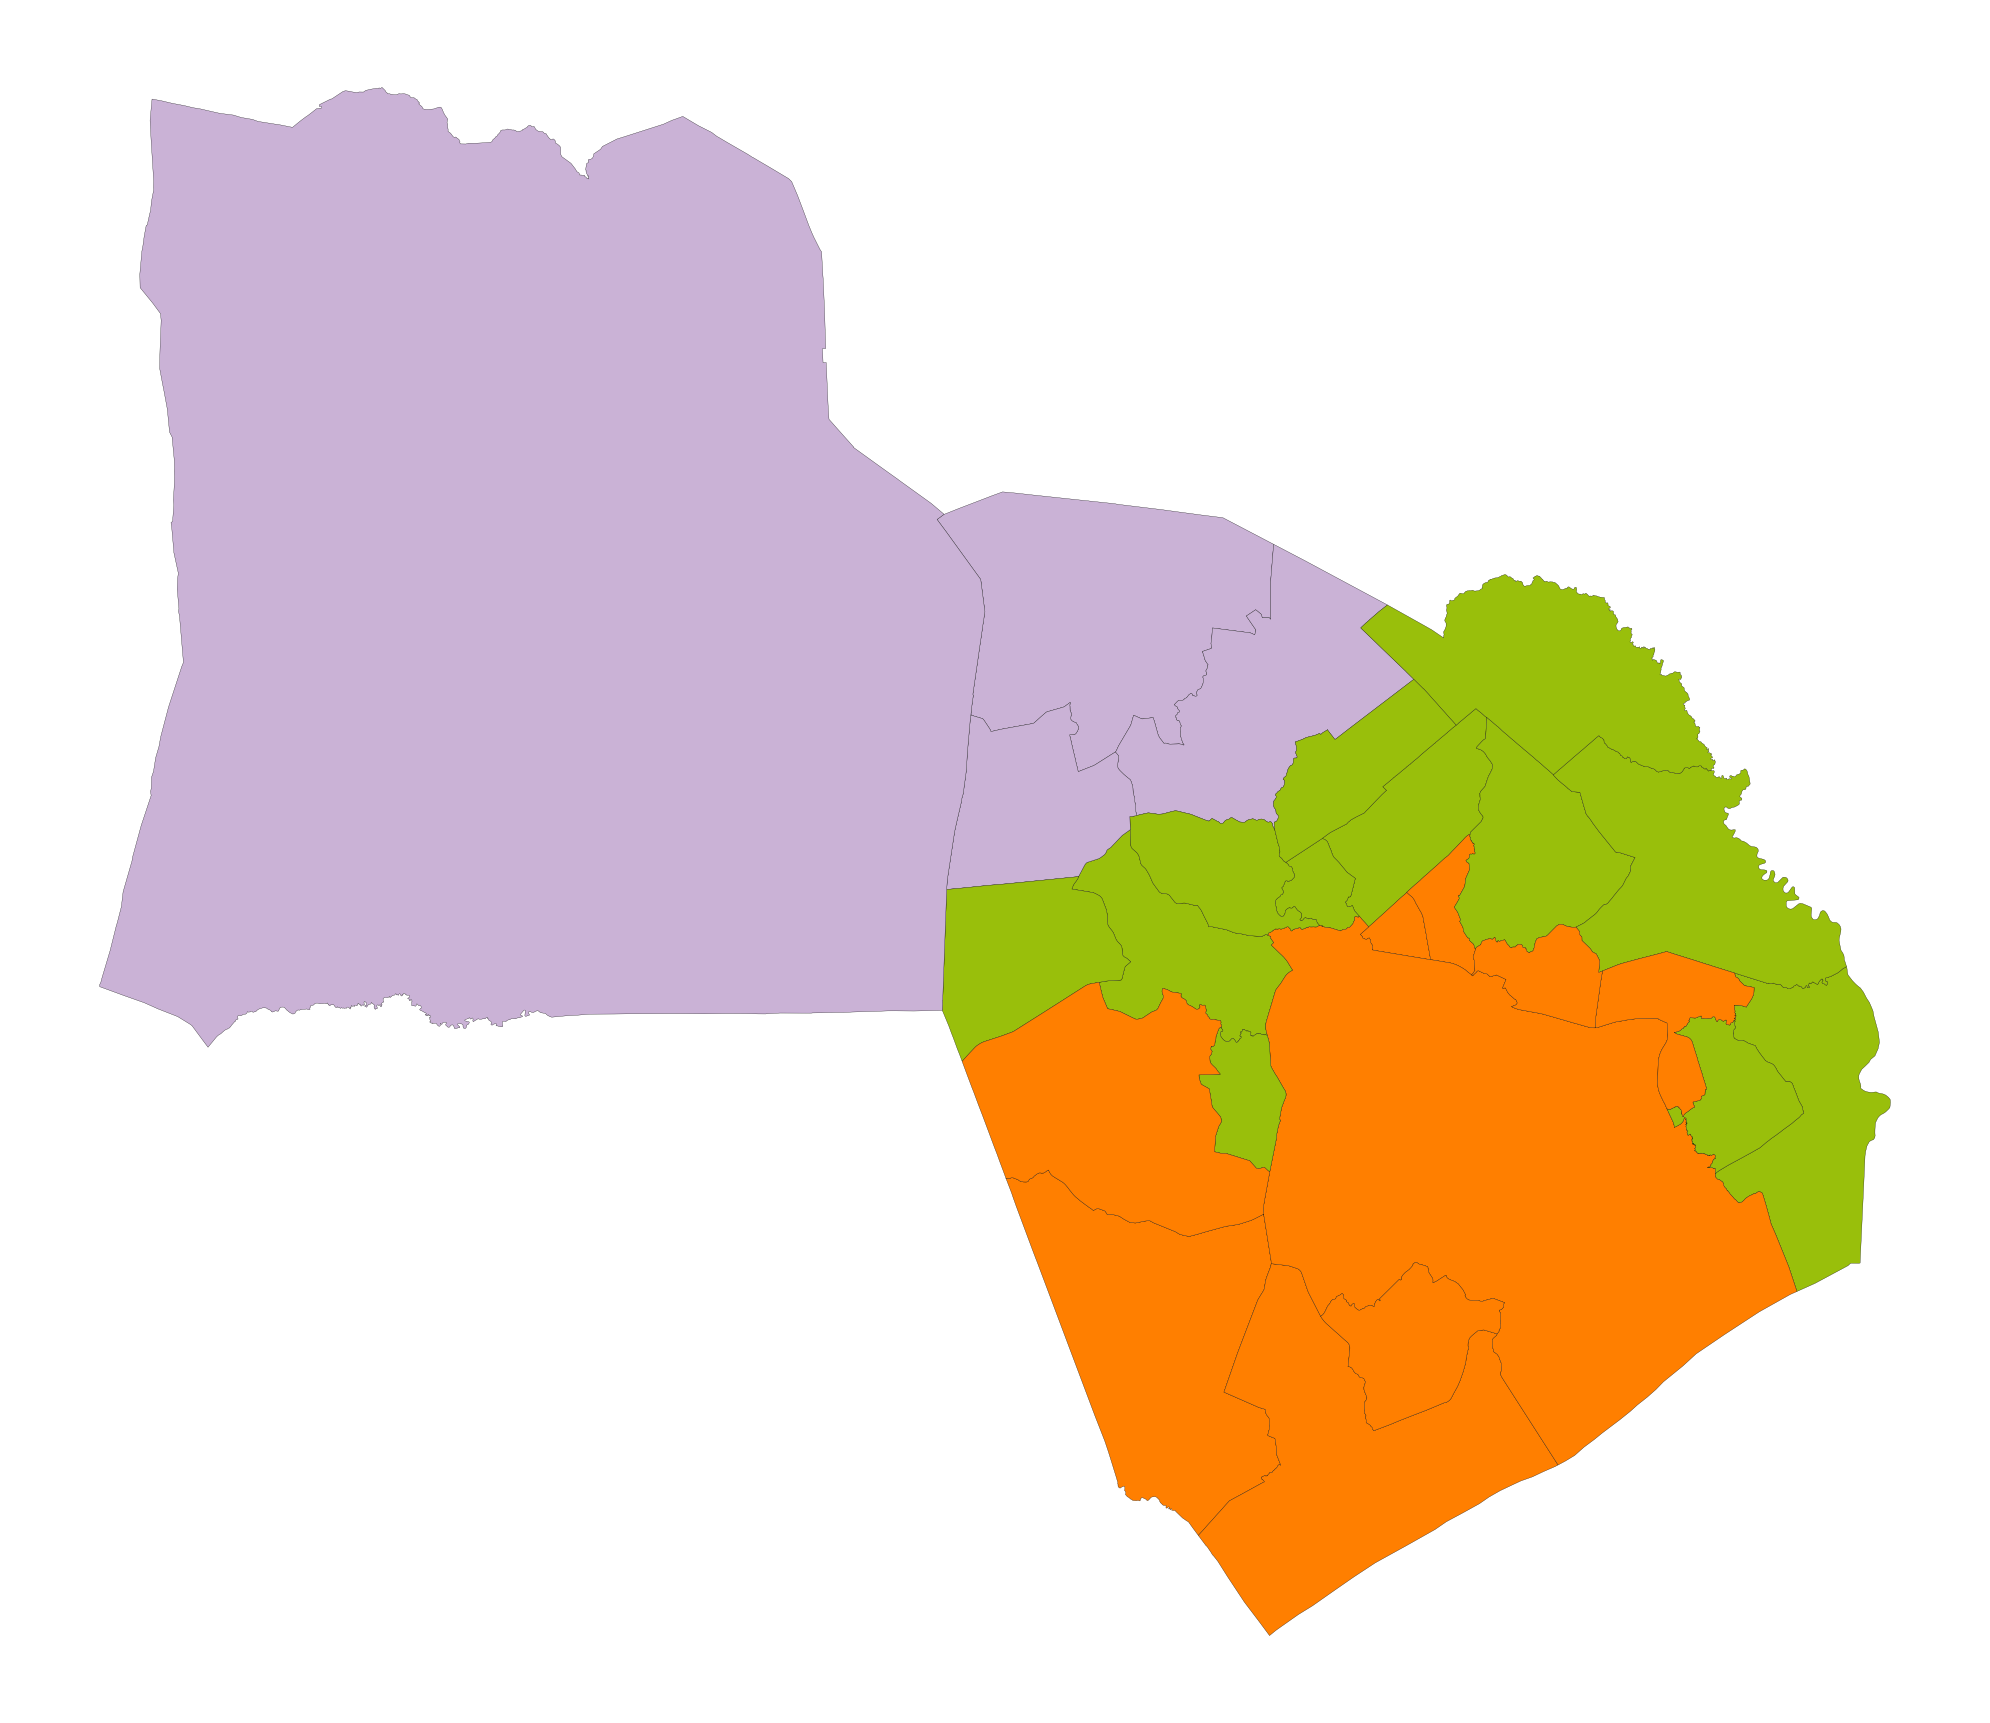

In [7]:
atlasPath = os.path.join("output/DO", "singleNodeFlip_gamma0.0.jsonl")
atlas = Atlas.openAtlas(atlasPath)
outDir = "/".join(atlasPath[:-len(".jsonl")].split("/"))
if not os.path.exists(outDir):
    os.mkdir(outDir)

mp = Atlas.nextMap(atlas)
do_pctSF = assignPlan(do_pctSF, mp.districting, "GEOID")
do_pctSF.plot(figsize=(20,20), vmin=1, vmax=3, column="dist", cmap=mycmap, 
           edgecolor="black", linewidth=0.2)
plt.axis("off")
plt.tight_layout()
Atlas.closeAtlas(atlas)


In [8]:
atlasPath = os.path.join("output/DO", "singleNodeFlip_gamma0.0.jsonl")
atlas = Atlas.openAtlas(atlasPath)
outDir = "/".join(atlasPath[:-len(".jsonl")].split("/"))
if not os.path.exists(outDir):
    os.mkdir(outDir)

mp = Atlas.nextMap(atlas)
while mp!=None:
    step = int(mp.name[len("step"):])
    vmx = max(mp.districting.values())
    mcmap = mycmap120 if vmx > 100 else mycmap50 if vmx > 30 else mycmap
    do_pctSF = assignPlan(do_pctSF, mp.districting, "GEOID")
    save_fig(do_pctSF, mcmap, vmx, outDir, mp.name)
    mp = Atlas.nextMap(atlas)
#     break

Atlas.closeAtlas(atlas)


In [10]:
atlasPath = os.path.join("output/NC", "singleNodeFlip_gamma0.0.jsonl")
atlas = Atlas.openAtlas(atlasPath)
outDir = "/".join(atlasPath[:-len(".jsonl")].split("/"))
if not os.path.exists(outDir):
    os.mkdir(outDir)

mp = Atlas.nextMap(atlas)
while mp!=None:
    step = int(mp.name[len("step"):])
    vmx = max(mp.districting.values())
    mcmap = mycmap120 if vmx > 100 else mycmap50 if vmx > 30 else mycmap
    nc_pctSF = assignPlan(nc_pctSF, mp.districting, "NAME")
    save_fig(nc_pctSF, mcmap, vmx, outDir, mp.name)
    mp = Atlas.nextMap(atlas)
#     break

Atlas.closeAtlas(atlas)


KeyboardInterrupt: 

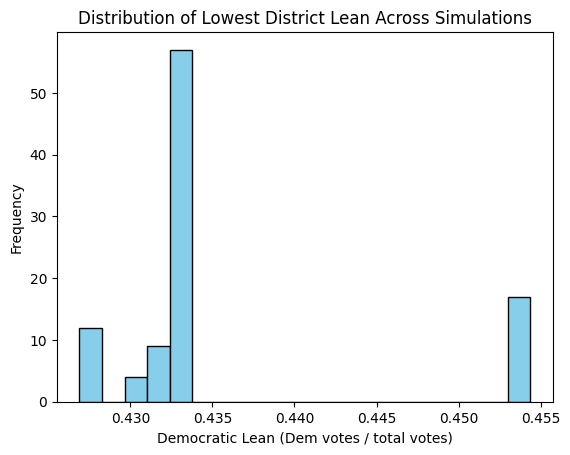

In [55]:
import json
atlasPath = os.path.join("output/DO", "singleNodeFlip_gamma0.0.jsonl")
graphPath = os.path.join("data","Duplin_Onslow.json")
def read_atlas(path):
    with open(path, 'r') as f:
        lines = f.readlines()

    # Strip whitespace and skip the first 3 lines
    lines = [line.strip() for line in lines if line.strip()]
    atlas_lines = lines[3:]

    steps = [json.loads(line) for line in atlas_lines]

    atlas = {
        "steps": steps
    }

    return atlas

def read_nodes_from_graph(path):
    with open(path, "r") as f:
        data = json.load(f)

    # Extract the 'nodes' list
    nodes = data.get("nodes", [])

    return nodes

dict = read_atlas(atlasPath)
graph = read_nodes_from_graph(graphPath)

final_results = []
for i in range(0,99):
    demvotes = {}
    repvotes = {}
    lean = {}
    for j in range(0,24):
        district_key = list(dict["steps"][i]["districting"][j].keys())[0]
        district = dict["steps"][i]["districting"][j].get(district_key)
        if district not in demvotes:
            demvotes[district] = graph[j].get("EL08G_LG_D")
            repvotes[district] = graph[j].get("EL08G_LG_R")
            lean[district] = demvotes[district] / (demvotes[district] + repvotes[district])
        else:
            demvotes[district]  += graph[j].get("EL08G_LG_D")
            repvotes[district]  += graph[j].get("EL08G_LG_R")
            lean[district] = demvotes[district] / (demvotes[district] + repvotes[district])
    final_results.append([demvotes,repvotes,lean])
#
import matplotlib.pyplot as plt

# Extract the lowest district lean (minimum) from each simulation
lowest_leans = []
for sim in final_results:
    lean = sim[2]  # third element = dictionary of leans by district
    min_lean = min(lean.values())  # district with lowest lean
    lowest_leans.append(min_lean)

# Plot histogram
plt.hist(lowest_leans, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Lowest District Lean Across Simulations")
plt.xlabel("Democratic Lean (Dem votes / total votes)")
plt.ylabel("Frequency")
plt.show()

['"This is an Atlas for Redistricting Maps. See \'https://git.math.duke.edu/gitlab/jonm/atlasio.jl\' for more information."\n', '{"description":"","date":"2025-10-22T11:55:31.483","atlasParamType":"Dict{String, Any}","mapParamType":"Dict{String, Any}"}\n', '{"energy weights":[],"levels in graph":["GEOID"],"population bounds":[74822,82696],"graph nodes by level":[25],"gamma":0.0,"graph edges by level":[60],"energies":[],"package.version":"MetropolizedForestRecom v0.1.2","districts":3}\n', '{"name":"step0","weight":1,"data":{"get_log_spanning_forests":13.138299716702685,"get_log_spanning_trees":[2.079441541679836,6.089044875446847,4.969813299576002],"get_isoperimetric_scores":[25.95757215770497,34.26554515407198,89.7813493370415]},"districting":[{"[\\"061\\"]":1},{"[\\"TL06\\"]":3},{"[\\"CR07\\"]":3},{"[\\"JA01\\"]":2},{"[\\"ML23\\"]":3},{"[\\"HR17\\"]":2},{"[\\"SW19\\"]":3},{"[\\"HU20\\"]":2},{"[\\"NM13\\"]":3},{"[\\"VR15\\"]":3},{"[\\"EN03\\"]":3},{"[\\"MT24\\"]":3},{"[\\"NR02\\"]":2},

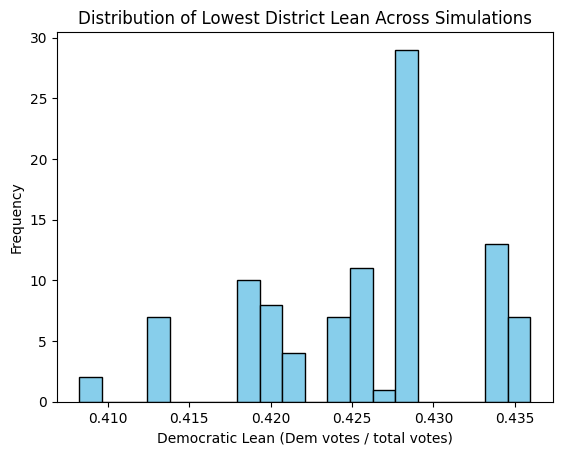

In [64]:
atlasPath = os.path.join("output/DO", "metropolizedRecombination_gamma0.0.jsonl")
graphPath = os.path.join("data","Duplin_Onslow.json")

with open(atlasPath, 'r') as f:
        lines = f.readlines()
print(lines)

def read_atlas(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    lines = [line.strip() for line in lines if line.strip()]
    atlas_lines = lines[3:]

    steps = [json.loads(line) for line in atlas_lines]

    atlas = {
        "steps": steps
    }

    return atlas

def read_nodes_from_graph(path):
    with open(path, "r") as f:
        data = json.load(f)

    # Extract the 'nodes' list
    nodes = data.get("nodes", [])

    return nodes
dict = read_atlas(atlasPath)
graph = read_nodes_from_graph(graphPath)

final_results = []
for i in range(0,99):
    demvotes = {}
    repvotes = {}
    lean = {}
    for j in range(0,24):
        district_key = list(dict["steps"][i]["districting"][j].keys())[0]
        district = dict["steps"][i]["districting"][j].get(district_key)
        if district not in demvotes:
            demvotes[district] = graph[j].get("EL08G_LG_D")
            repvotes[district] = graph[j].get("EL08G_LG_R")
            lean[district] = demvotes[district] / (demvotes[district] + repvotes[district])
        else:
            demvotes[district]  += graph[j].get("EL08G_LG_D")
            repvotes[district]  += graph[j].get("EL08G_LG_R")
            lean[district] = demvotes[district] / (demvotes[district] + repvotes[district])
    final_results.append([demvotes,repvotes,lean])

import matplotlib.pyplot as plt


lowest_leans = []
for sim in final_results:
    lean = sim[2] 
    min_lean = min(lean.values())  
    lowest_leans.append(min_lean)


plt.hist(lowest_leans, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Lowest District Lean Across Simulations")
plt.xlabel("Democratic Lean (Dem votes / total votes)")
plt.ylabel("Frequency")
plt.show()

In [72]:
atlasPath = os.path.join("output/NC", "singleNodeFlip_gamma0.0.jsonl")
graphPath = os.path.join("data","Duplin_Onslow.json")

with open(atlasPath, 'r') as f:
        lines = f.readlines()
#print(lines[1:10])
steps = [json.loads(line) for line in lines]

In [ ]:
atlasPath = os.path.join("output/NC", "singleNodeFlip_gamma0.0.jsonl")
graphPath = os.path.join("data","Duplin_Onslow.json")


def read_atlas(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    lines = [line.strip() for line in lines if line.strip()]
    atlas_lines = lines[3:]

    steps = [json.loads(line) for line in atlas_lines]

    atlas = {
        "steps": steps
    }

    return atlas

def read_nodes_from_graph(path):
    with open(path, "r") as f:
        data = json.load(f)

    # Extract the 'nodes' list
    nodes = data.get("nodes", [])

    return nodes
dict = read_atlas(atlasPath)
graph = read_nodes_from_graph(graphPath)
print(len(list(dict["steps"][i]["districting"])))
final_results = []
for i in range(0,99):
    demvotes = {}
    repvotes = {}
    lean = {}
    for j in range(0,26):
        district_key = list(dict["steps"][i]["districting"][j].keys())[0]
        district = dict["steps"][i]["districting"][j].get(district_key)
        if district not in demvotes:
            demvotes[district] = graph[j].get("EL08G_LG_D")
            repvotes[district] = graph[j].get("EL08G_LG_R")
            lean[district] = demvotes[district] / (demvotes[district] + repvotes[district])
        else:
            demvotes[district]  += graph[j].get("EL08G_LG_D")
            repvotes[district]  += graph[j].get("EL08G_LG_R")
            lean[district] = demvotes[district] / (demvotes[district] + repvotes[district])
    final_results.append([demvotes,repvotes,lean])

import matplotlib.pyplot as plt


lowest_leans = []
for sim in final_results:
    lean = sim[2] 
    min_lean = min(lean.values())  
    lowest_leans.append(min_lean)


#plt.hist(lowest_leans, bins=20, color='skyblue', edgecolor='black')
#plt.title("Distribution of Lowest District Lean Across Simulations")
#plt.xlabel("Democratic Lean (Dem votes / total votes)")
#plt.ylabel("Frequency")
#plt.show()

2650


['"This is an Atlas for Redistricting Maps. See \'https://git.math.duke.edu/gitlab/jonm/atlasio.jl\' for more information."\n', '{"description":"","date":"2025-10-22T11:57:27.940","atlasParamType":"Dict{String, Any}","mapParamType":"Dict{String, Any}"}\n', '{"energy weights":[],"levels in graph":["county_and_prec_id"],"population bounds":[730758,760583],"graph nodes by level":[2650],"gamma":0.0,"graph edges by level":[7490],"energies":[],"package.version":"MetropolizedForestRecom v0.1.2","districts":14}\n', '{"name":"step0","weight":1,"data":{"get_log_spanning_forests":3414.6233338691786,"get_log_spanning_trees":[319.92808363937957,240.8824808677563,160.57981781174183,409.3109341833179,205.6275189044183,307.3330256564173,302.61378162455816,182.3777304261725,187.72411052726224,252.28458350535163,178.33701791187372,253.92486843069443,259.11037597191455,154.58900440831997],"get_isoperimetric_scores":[45.38781096658934,78.7305038298208,83.58082289499198,55.82902142622575,124.90639849081474

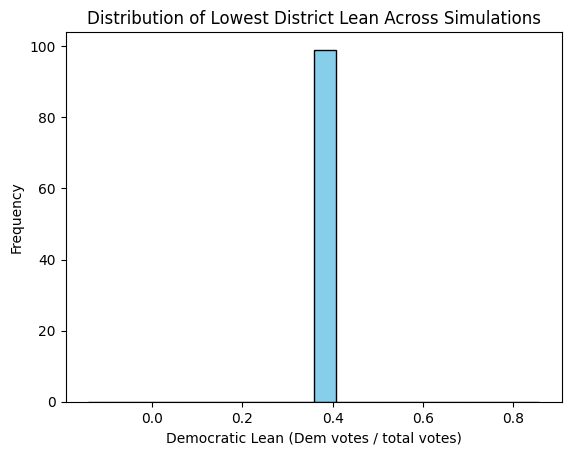

In [65]:
atlasPath = os.path.join("output/NC", "metropolizedRecombination_gamma0.0.jsonl")
graphPath = os.path.join("data","Duplin_Onslow.json")

with open(atlasPath, 'r') as f:
        lines = f.readlines()
print(lines)

def read_atlas(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    lines = [line.strip() for line in lines if line.strip()]
    atlas_lines = lines[3:]

    steps = [json.loads(line) for line in atlas_lines]

    atlas = {
        "steps": steps
    }

    return atlas

def read_nodes_from_graph(path):
    with open(path, "r") as f:
        data = json.load(f)

    # Extract the 'nodes' list
    nodes = data.get("nodes", [])

    return nodes
dict = read_atlas(atlasPath)
graph = read_nodes_from_graph(graphPath)

final_results = []
for i in range(0,99):
    demvotes = {}
    repvotes = {}
    lean = {}
    for j in range(0,24):
        district_key = list(dict["steps"][i]["districting"][j].keys())[0]
        district = dict["steps"][i]["districting"][j].get(district_key)
        if district not in demvotes:
            demvotes[district] = graph[j].get("EL08G_LG_D")
            repvotes[district] = graph[j].get("EL08G_LG_R")
            lean[district] = demvotes[district] / (demvotes[district] + repvotes[district])
        else:
            demvotes[district]  += graph[j].get("EL08G_LG_D")
            repvotes[district]  += graph[j].get("EL08G_LG_R")
            lean[district] = demvotes[district] / (demvotes[district] + repvotes[district])
    final_results.append([demvotes,repvotes,lean])

import matplotlib.pyplot as plt


lowest_leans = []
for sim in final_results:
    lean = sim[2] 
    min_lean = min(lean.values())  
    lowest_leans.append(min_lean)


plt.hist(lowest_leans, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Lowest District Lean Across Simulations")
plt.xlabel("Democratic Lean (Dem votes / total votes)")
plt.ylabel("Frequency")
plt.show()